# 01. Preprocessing & Pipeline Verification

## Overview
This notebook serves as the initial integration test for the ETL (Extract, Transform, Load) pipeline. It validates raw data ingestion, verifies resampling logic, and ensures windowing operations preserve signal integrity.

## Objectives
1.  **Ingestion**: Verify `WESADPreprocessor` correctly parses the complex pickle structure of the raw dataset.
2.  **SQI (Signal Quality)**: Visualize "Dead Sensor" and "Motion Artifact" detection logic.
3.  **Windowing**: Confirm that 60s windows with overlap are generated correctly and align with subject boundaries.


In [1]:
# 1. Imports & Setup
%load_ext autoreload
%autoreload 2

# Standard Library Imports
import copy
import sys
from pathlib import Path

import matplotlib.pyplot as plt

# Third-Party Imports
import numpy as np

# Project-Specific Imports
# Add project root to path
project_root = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

from src.config import load_config
from src.data.make_dataset import WESADPreprocessor
from src.features.sqi import SignalQualityIndex
from src.visualization.plots import (
    plot_raw_signals,
    plot_resampling_verification_grid,
    plot_sqi_comparison,
    set_plot_style,
)

# Apply global configuration
set_plot_style()
config = load_config()

print("Setup Complete.")
print(f"Project Root: {project_root}")
print(f"Data Modalities: {config['data']['modalities']}")

Setup Complete.
Project Root: c:\Users\matteucc\Desktop\Portfolio_improvement\Wearable_stress_biomarker
Data Modalities: ['EDA', 'ACC', 'TEMP', 'RESP', 'BVP']


## 1. Load Raw Data (Subject S2)
We use the helper method from our preprocessor to load the pickle file directly.

In [2]:
# Verify pipeline sensor location configuration
sensor_loc = config["data"].get("sensor_location", "chest").upper()
print(f"Current Pipeline Location: {sensor_loc}")
# Note: 'CHEST' or 'WRIST' is defined in configs/default.yaml

Current Pipeline Location: CHEST


In [3]:
# 2. Load Raw Subject Data

# Initialize Preprocessor (Requires data/raw/WESAD to be populated)
preprocessor = WESADPreprocessor()

# Define Subject ID for Verification
subject_id = "S2"

# Load data into memory
data = preprocessor.load_subject(subject_id)
print(f"Successfully loaded {subject_id}.")
print(f"Available Keys: {list(data.keys())}")
print(f"Signal Modalities: {list(data['signal']['chest'].keys())}")

2026-01-18 19:02:42,434 - src.data.make_dataset - INFO - Loading C:\Users\matteucc\Desktop\Portfolio_improvement\Wearable_stress_biomarker\data\raw\WESAD\S2\S2.pkl
Successfully loaded S2.
Available Keys: ['signal', 'label', 'subject']
Signal Modalities: ['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp']


## 2. Visualize Raw Signals
Let's look at 60 seconds of raw data. The chest data is at 700Hz.

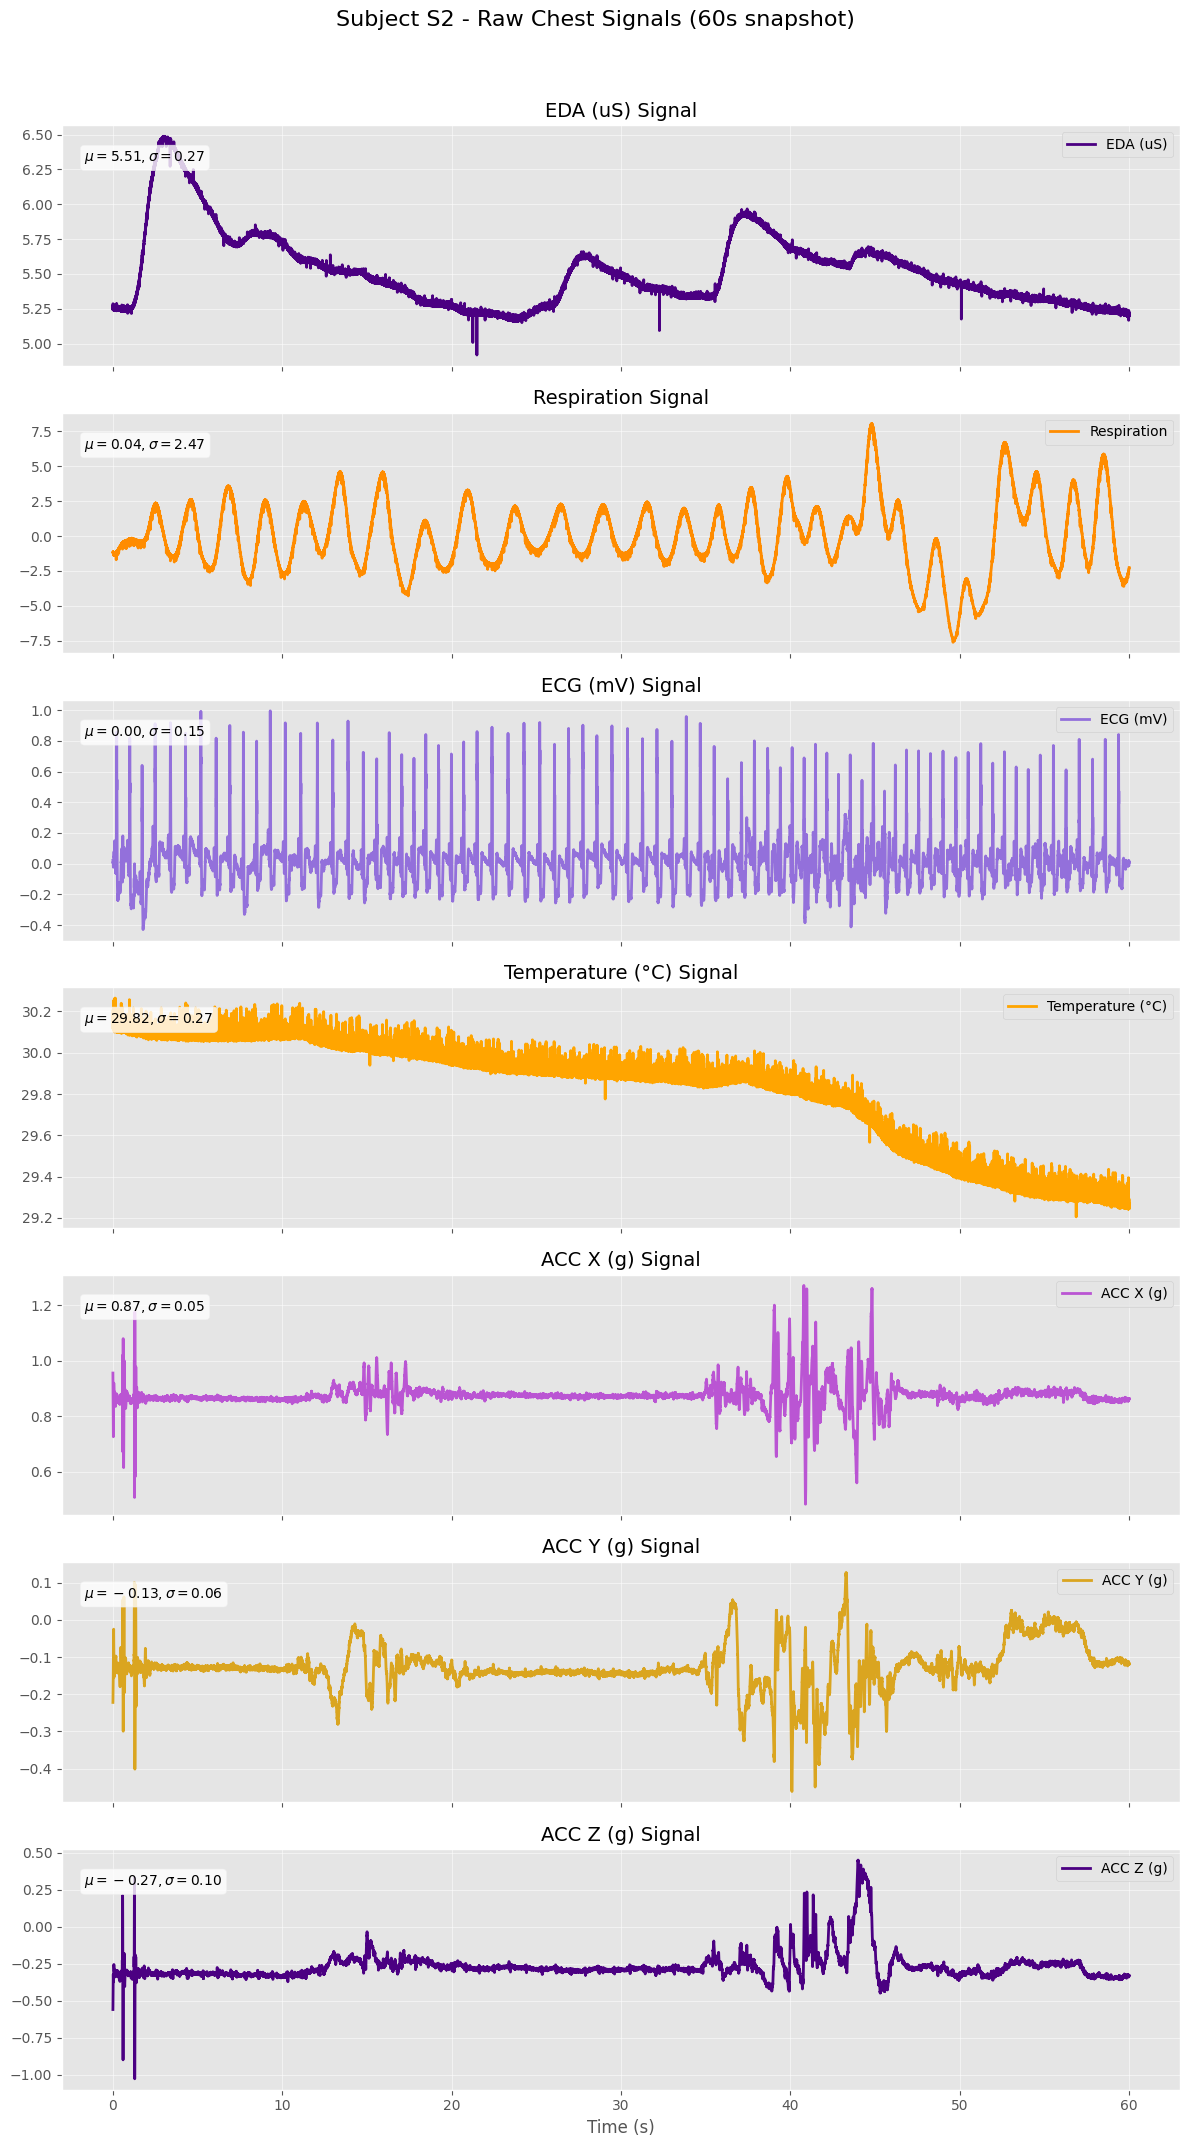

In [4]:
# 3. Visualize Raw Physiological Signals

# Extract chest data
chest_data = data["signal"]["chest"]

# WESAD constants
RAW_FS = 700  # Raw sampling rate is 700Hz for Chest data
DURATION_SEC = 60
num_samples = RAW_FS * DURATION_SEC

# Prepare dictionary for plotting
# Flatten arrays to ensures 1D vectors for plotting
plotting_data = {
    "EDA (uS)": chest_data["EDA"][:num_samples].flatten(),
    "Respiration": chest_data["Resp"][:num_samples].flatten(),
    "ECG (mV)": chest_data["ECG"][:num_samples].flatten(),
    "Temperature (°C)": chest_data["Temp"][:num_samples].flatten(),
    "ACC X (g)": chest_data["ACC"][:num_samples, 0].flatten(),
    "ACC Y (g)": chest_data["ACC"][:num_samples, 1].flatten(),
    "ACC Z (g)": chest_data["ACC"][:num_samples, 2].flatten(),
}

# Generate time axis
time_axis = np.arange(num_samples) / RAW_FS

# Plot using utility function
sensor_loc = config["data"].get("sensor_location", "chest").upper()
fig = plot_raw_signals(
    time_axis,
    plotting_data,
    title=f"Subject {subject_id} - Raw Chest Signals ({DURATION_SEC}s snapshot)",
    save_folder=sensor_loc,
)
plt.show()

## 3. Verify Resampling & Windowing
Our pipeline downsamples to 35Hz to make the data manageable for ML.
Let's run the `process_subject` method and inspect the first generated window.

In [5]:
# 4. Process Subject (Windowing & Downsampling)

# Execute the main processing logic from src/data/make_dataset.py
print(f"Processing {subject_id} (Windowing + Downsampling)...")
windows = preprocessor.process_subject(subject_id)

print(f"Generated {len(windows)} windows.")

# Inspect the structure of the first window
sample_window = windows[0]
print("Window Structure:", list(sample_window.keys()))
print("EDA Shape:", np.array(sample_window["EDA"]).shape)
print("Label:", sample_window["label"])

Processing S2 (Windowing + Downsampling)...
2026-01-18 19:02:46,464 - src.data.make_dataset - INFO - Loading C:\Users\matteucc\Desktop\Portfolio_improvement\Wearable_stress_biomarker\data\raw\WESAD\S2\S2.pkl
2026-01-18 19:02:55,087 - src.data.make_dataset - INFO - Subject S2: 71 windows created.
Generated 71 windows.
Window Structure: ['subject_id', 'label', 'start_idx', 'ACC_x', 'ACC_y', 'ACC_z', 'ECG', 'EDA', 'RESP', 'TEMP']
EDA Shape: (2100,)
Label: 1


Alignment Check: First window starts at t=300.00s


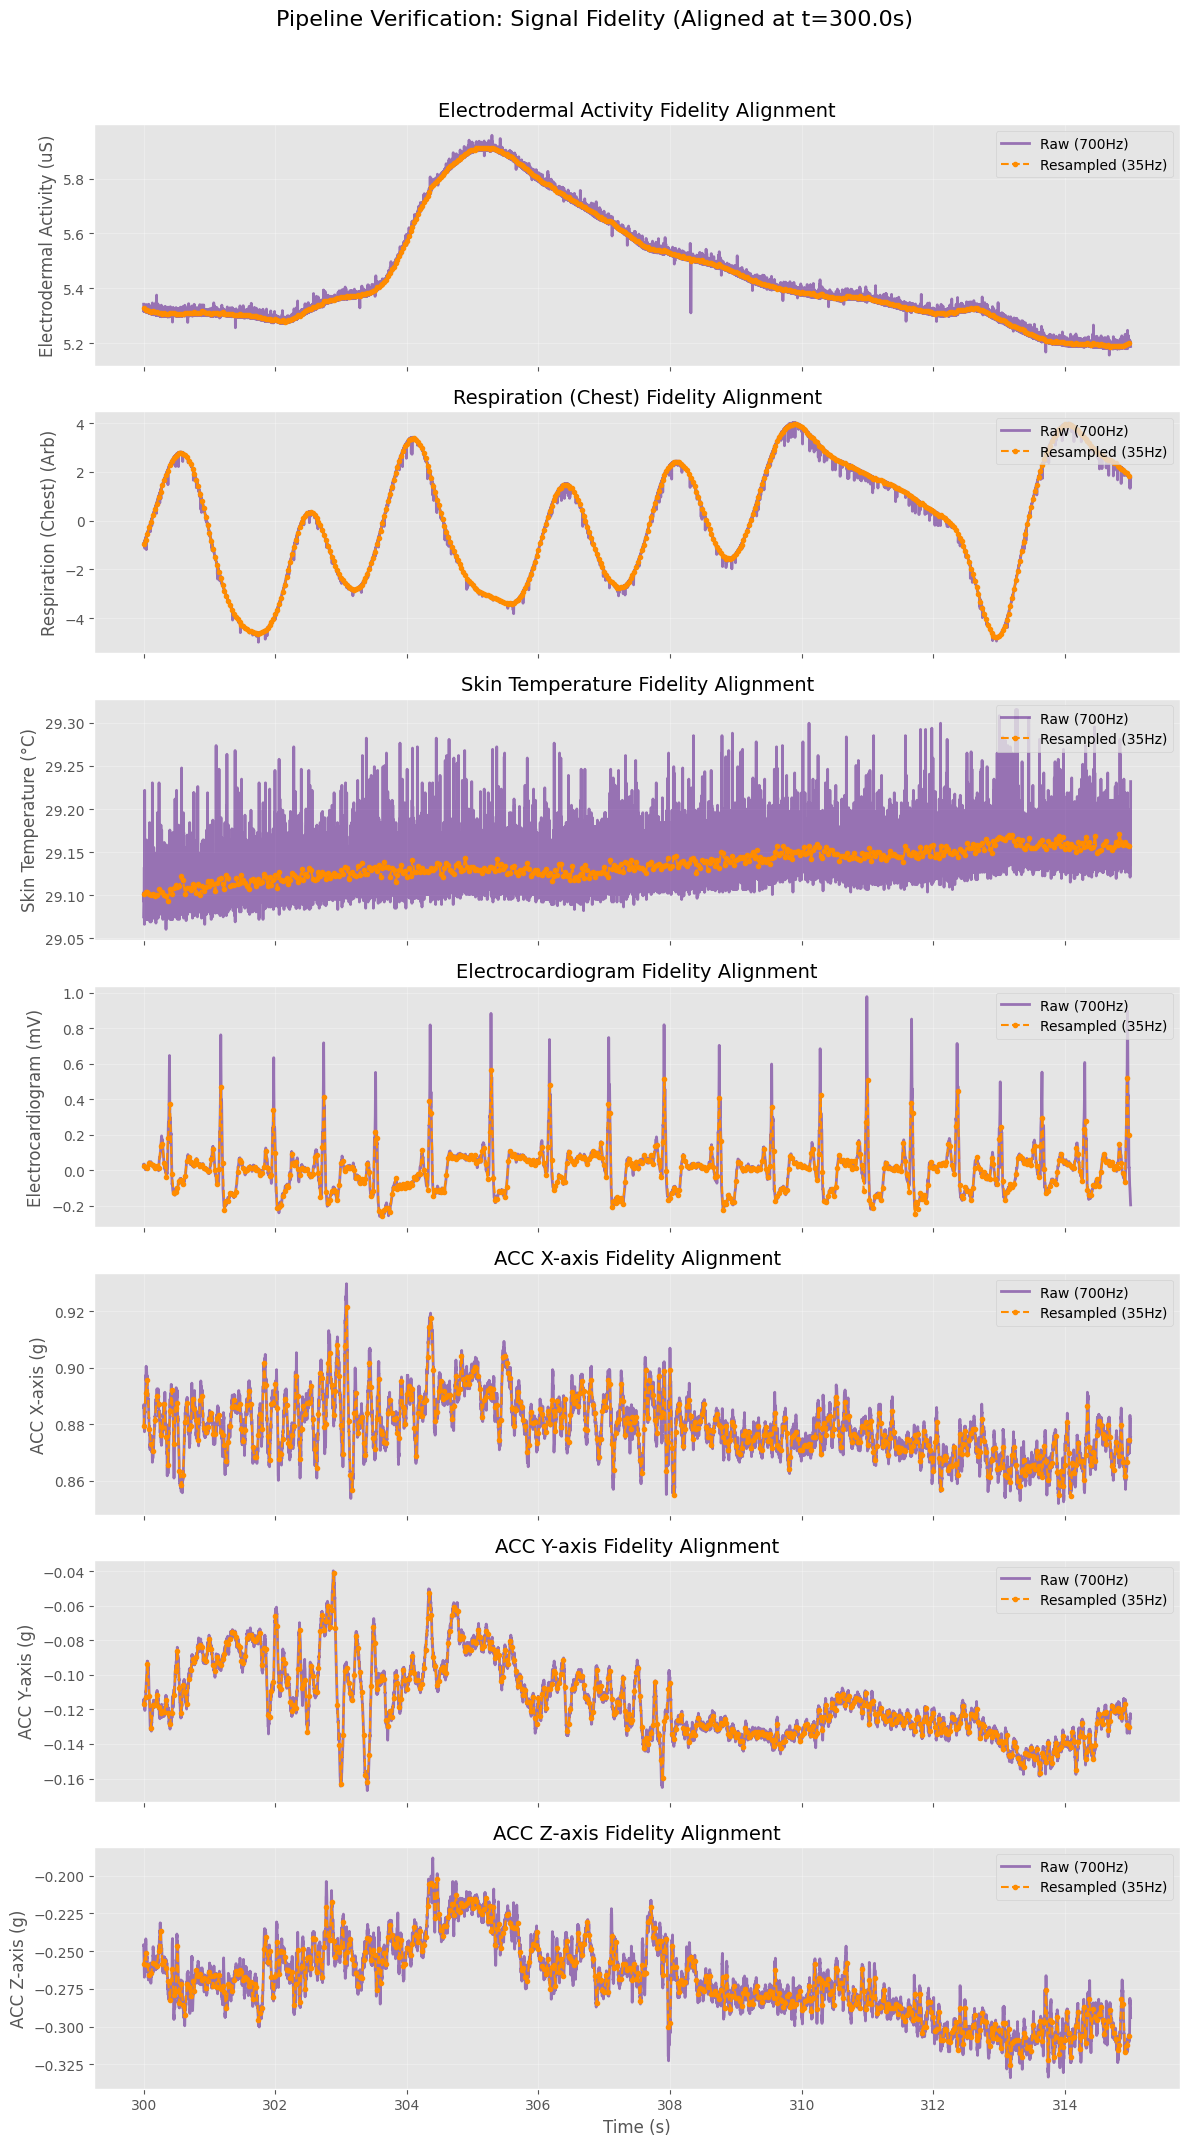

In [6]:
# 5. Visual Verification of Downsampling

# Define Parameters
RAW_FS = 700
TARGET_FS = preprocessor.target_fs  # 35Hz as per config
PLOT_DURATION = 15  # Seconds to visualize

# Retrieve start time of the first window for alignment
start_time = sample_window["start_idx"] / TARGET_FS
print(f"Alignment Check: First window starts at t={start_time:.2f}s")

sensor_loc = config["data"].get("sensor_location", "chest").upper()

# Plot grid comparing Raw vs Downsampled signals
fig = plot_resampling_verification_grid(
    chest_data,
    sample_window,
    start_time,
    raw_fs=RAW_FS,
    target_fs=TARGET_FS,
    plot_duration=PLOT_DURATION,
    save_folder=sensor_loc,
)
plt.show()

## 4. Signal Quality Index (SQI) Check
The **Signal Quality Index (SQI)** module is a critical "Gatekeeper" layer. It prevents garbage data from reaching the ML model by flagging windows with sensor disconnects or excessive motion noise.

**Metrics & Logic:**
The `overall_sqi` score (0.0 to 1.0) is a composite of multiple checks defined in `src/features/sqi.py` and configured via `configs/default.yaml`.

*   **Dead Sensor Check (Connectivity)**:
    *   Detects "Flatlines" where the signal variance is suspiciously low (e.g., sensor fell off).
    *   **EDA**: Flatline if range < 0.005 $\mu S$.
    *   **Temp**: Flatline if range < 0.01 $^\circ C$.
    *   **ECG**: Flatline if range < 0.05 mV.
*   **Noise Check (Reliability)**:
    *   **Motion**: Detects high-intensity activity using the 3-axis Accelerometer.
    *   **Threshold**: Windows with ACC Standard Deviation > 0.5g are flagged as noisy.

**Interpretation:**
Windows with `overall_sqi < 0.7` are rejected during the training pipeline.
*   **Left Plots**: Physiological Signal (Red line indicates flatline threshold).
*   **Right Plots**: Motion intensity (Red line indicates noise threshold).

--- Running SQI Tests for: ECG ---
Flatline Threshold: 0.05 (from config)


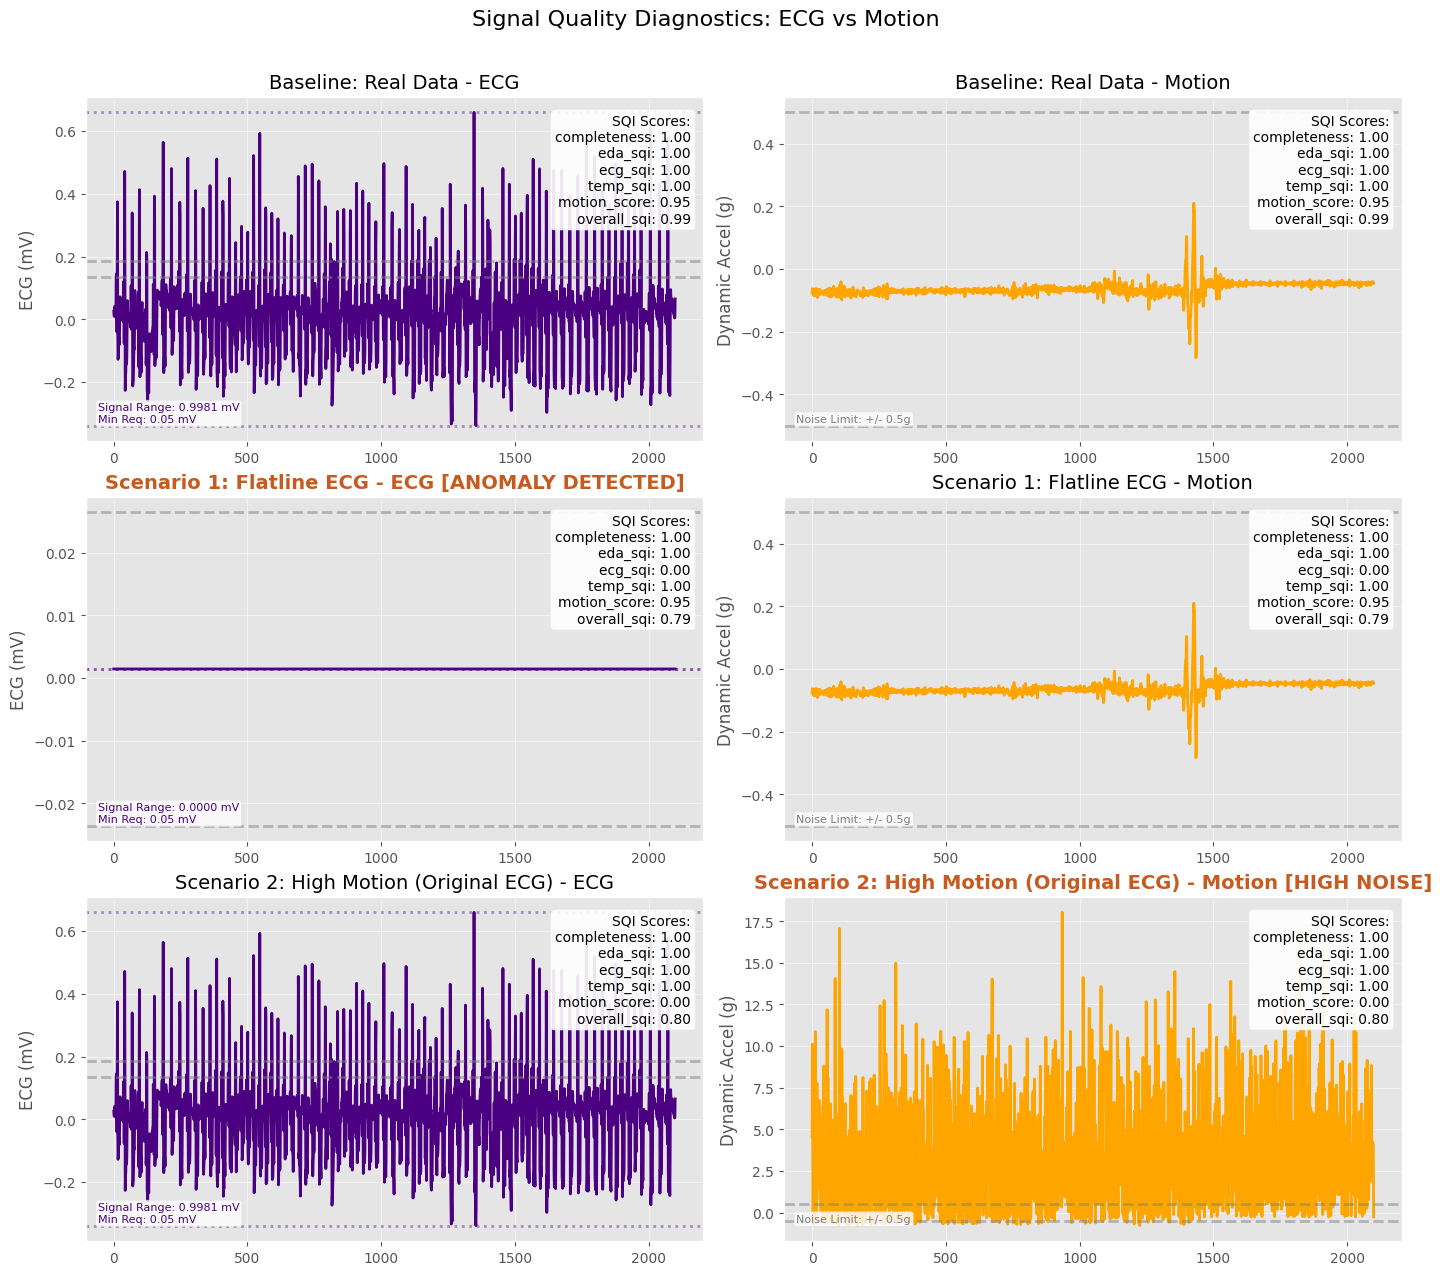

In [7]:
# 6. Signal Quality Index (SQI) Simulation

# Initialize SQI Calculator
sqi = SignalQualityIndex(config)

# Select signal to test
TEST_SIGNAL = "ECG"
print(f"--- Running SQI Tests for: {TEST_SIGNAL} ---")
print(f"Flatline Threshold: {sqi.flatline_thresholds.get(TEST_SIGNAL)} (from config)")

scenarios = []

# Scenario 1: Real Data (Baseline)
real_window = windows[0]
real_score = sqi.compute_sqi(real_window)
scenarios.append((real_window, "Baseline: Real Data", real_score))

# Scenario 2: Synthetic Flatline (Sensor Disconnect)
flat_window = copy.deepcopy(windows[0])
signal_mean = np.mean(flat_window[TEST_SIGNAL])
# Force signal to constant value
flat_window[TEST_SIGNAL] = np.ones_like(flat_window[TEST_SIGNAL]) * signal_mean
flat_score = sqi.compute_sqi(flat_window)
scenarios.append((flat_window, f"Scenario 1: Flatline {TEST_SIGNAL}", flat_score))

# Scenario 3: Synthetic Motion Artifact
noisy_window = copy.deepcopy(windows[0])
# Inject Gaussian noise into Accelerometer
noisy_window["ACC_x"] = np.random.normal(0, 5, len(noisy_window["ACC_x"]))
noisy_score = sqi.compute_sqi(noisy_window)
scenarios.append(
    (noisy_window, f"Scenario 2: High Motion (Original {TEST_SIGNAL})", noisy_score)
)

# Visualize comparisons
fig = plot_sqi_comparison(
    scenarios, signal_key=TEST_SIGNAL, thresholds=sqi.flatline_thresholds
)
plt.show()

## 5. Real-World Audit
Finally, let's run the full **Signal Quality Index (SQI)** algorithm on **every single window** generated for this subject and inspect some of them visually.

Auditing all 71 windows for Subject S2...
Target Signal: ECG
Acceptance Threshold (SQI): >= 0.7

--- Audit Report ---
Total Windows: 71
Accepted: 71 (100.0%)
Rejected: 0 (0.0%)

--- Representative Windows ---
Best (Idx 60):   Score = 0.9993
Median (Idx 17): Score = 0.9981
Worst (Idx 37):  Score = 0.9734


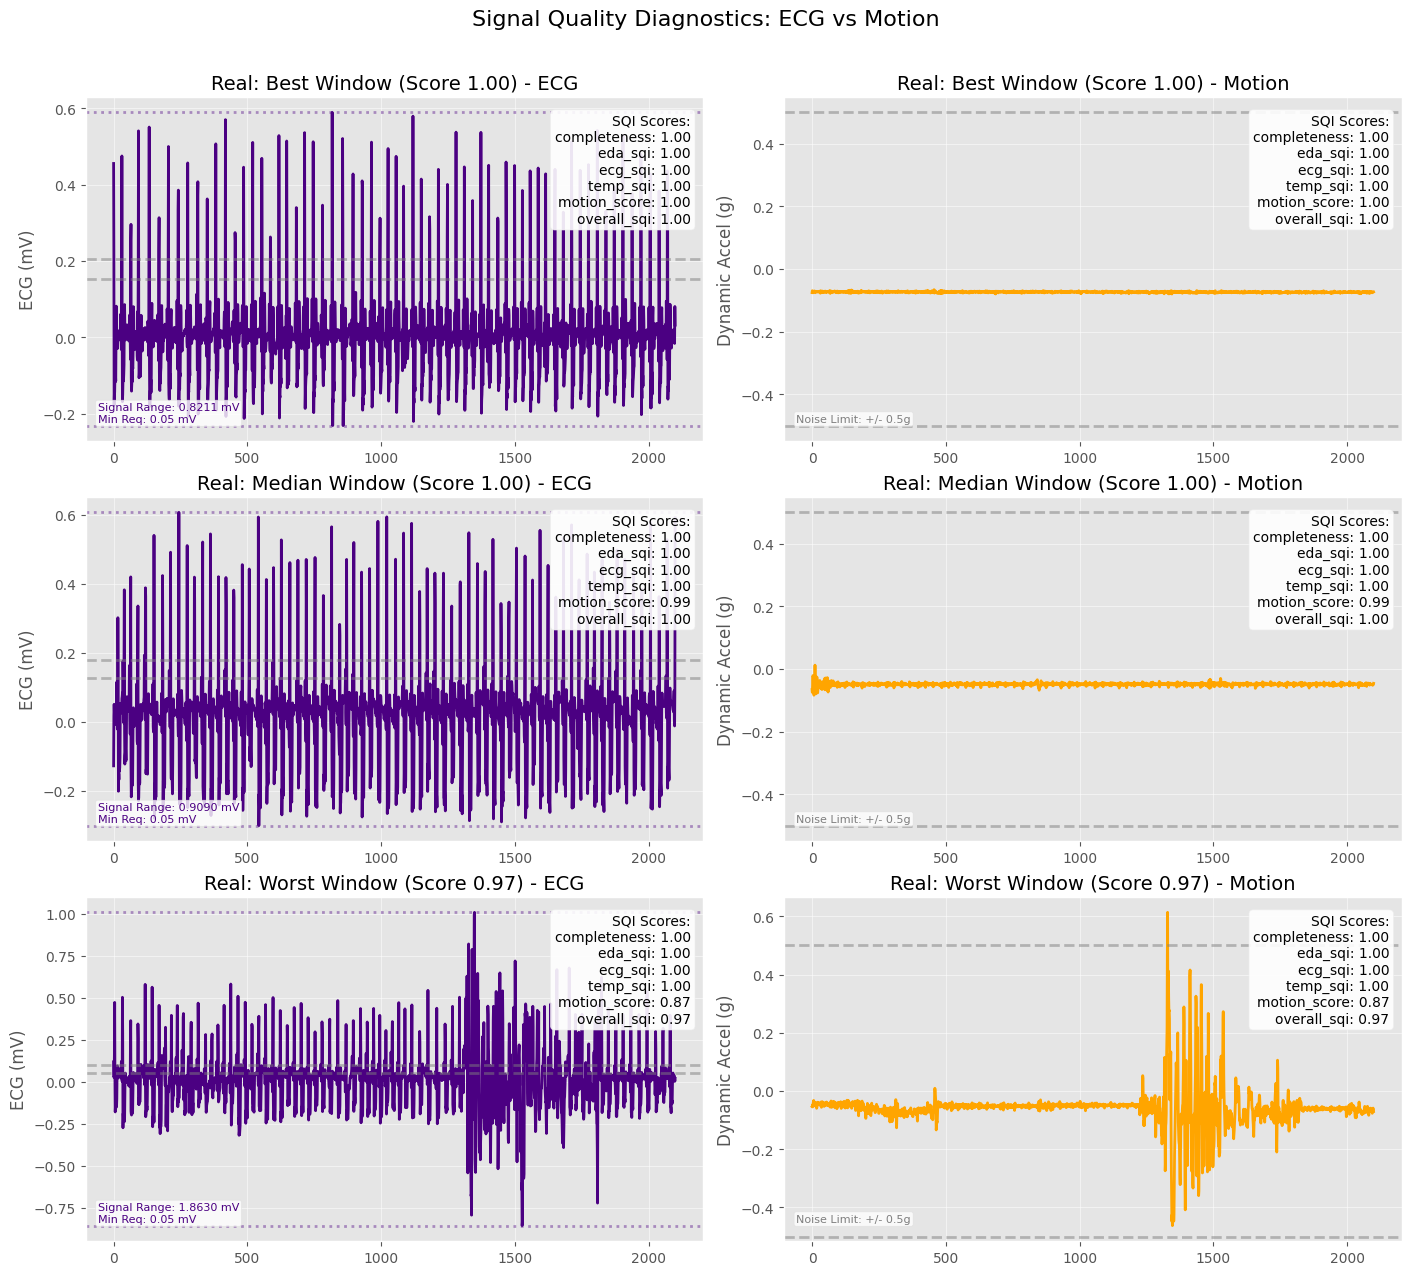

In [8]:
# 7. Full Subject Audit

print(f"Auditing all {len(windows)} windows for Subject {subject_id}...")
AUDIT_SIGNAL = "ECG"
ACCEPTANCE_THRESHOLD = sqi.acceptance_threshold

print(f"Target Signal: {AUDIT_SIGNAL}")
print(f"Acceptance Threshold (SQI): >= {ACCEPTANCE_THRESHOLD}")

# Calculate SQI for all windows
audit_results = []
for i, win in enumerate(windows):
    is_good = sqi.is_acceptable(win)
    scores = sqi.compute_sqi(win)
    audit_results.append({"index": i, "is_good": is_good, "scores": scores})

# Compute Statistics
good_count = sum(1 for r in audit_results if r["is_good"])
bad_count = len(audit_results) - good_count

print("\n--- Audit Report ---")
print(f"Total Windows: {len(windows)}")
print(f"Accepted: {good_count} ({good_count / len(windows) * 100:.1f}%)")
print(f"Rejected: {bad_count} ({bad_count / len(windows) * 100:.1f}%)")

# Identify Extreme Cases
scores_list = [r["scores"]["overall_sqi"] for r in audit_results]
best_idx = np.argmax(scores_list)
worst_idx = np.argmin(scores_list)
sorted_indices = np.argsort(scores_list)
median_idx = sorted_indices[len(scores_list) // 2]

print("\n--- Representative Windows ---")
print(f"Best (Idx {best_idx}):   Score = {scores_list[best_idx]:.4f}")
print(f"Median (Idx {median_idx}): Score = {scores_list[median_idx]:.4f}")
print(f"Worst (Idx {worst_idx}):  Score = {scores_list[worst_idx]:.4f}")

# Visualize Extremes
real_scenarios = [
    (
        windows[best_idx],
        f"Real: Best Window (Score {scores_list[best_idx]:.2f})",
        audit_results[best_idx]["scores"],
    ),
    (
        windows[median_idx],
        f"Real: Median Window (Score {scores_list[median_idx]:.2f})",
        audit_results[median_idx]["scores"],
    ),
    (
        windows[worst_idx],
        f"Real: Worst Window (Score {scores_list[worst_idx]:.2f})",
        audit_results[worst_idx]["scores"],
    ),
]

sensor_loc = config["data"].get("sensor_location", "chest").upper()
fig = plot_sqi_comparison(
    real_scenarios,
    signal_key=AUDIT_SIGNAL,
    thresholds=sqi.flatline_thresholds,
    save_folder=sensor_loc,
)
plt.show()